# Regression

In the past couple weeks, we have been working with classification. We go a step further here with regression. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import neighbors

%matplotlib inline

### Upload our data set - WDs spectroscopically identified in SDSS

In [3]:
wds = np.load("SDSS_DR7_WDs.npy")

print(wds.dtype)
print(wds.shape)

[('ra', '<f8'), ('dec', '<f8'), ('u', '<f8'), ('g', '<f8'), ('r', '<f8'), ('i', '<f8'), ('z', '<f8'), ('u_err', '<f8'), ('g_err', '<f8'), ('r_err', '<f8'), ('i_err', '<f8'), ('z_err', '<f8'), ('Teff', '<f8'), ('logg', '<f8'), ('Teff_err', '<f8'), ('logg_err', '<f8')]
(13418,)


### The problem: spectra are expensive!

Machine learning works best when we have a large data set that we want to learn something about, but only a small subset have the necessary data from which we can apply more classical methods. A clear example of this is deriving characteristics of a dataset using spectra, and SDSS is an excellent data set for demonstration. 

I will focus on white dwarfs (WDs), since I have some familiarity with these data. Some characteristics of WDs necessary for this exercise:

* WDs are small (something like the Earth's radius), degenerate stars which typically have no nuclear burning.
* Typical masses are ~0.65 M$_{\odot}$, giving them large surface gravities: log $g$ $\approx$ 8.
* "DA" WDs, the data set we will be working with here, have hydrogren atmospheres.
* The spectra of DA WDs are blackbodies with very broad H Balmer lines due to the high log $g$.
* WDs are typically hot (therefore blue); after 1 Gyr, they cool to $\approx$ 8500 K.


### Typically, spectra are needed to derive T$_{\rm eff}$ and log $g$. Here, we want to try to see if we can use machine learning to derive T$_{\rm eff}$ and log $g$ from photometry alone.

We will use the set of spectroscopically characterized WDs from SDSS DR7 to train our model.

### Let's look at our data - Color shows the effective temperature

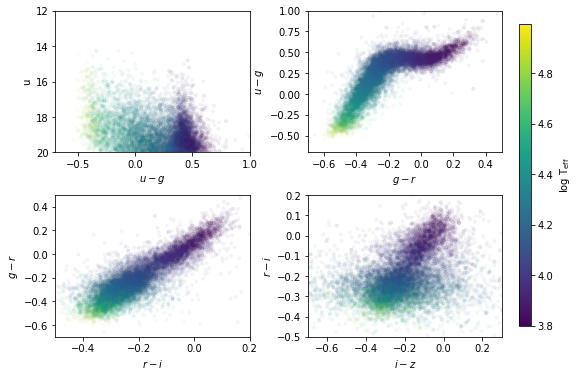

In [10]:
fig, ax = plt.subplots(2,2, figsize=(8,6))

labels = ['u', '$u-g$', '$g-r$', '$r-i$', '$i-z$']
vals = [wds['u'], wds['u']-wds['g'], wds['g']-wds['r'], wds['r']-wds['i'], wds['i']-wds['z']]
limits = [(20, 12), (-0.7,1), (-0.7, 0.5), (-0.5, 0.2), (-0.7, 0.3)]

# Iterate through all four panels
for i in range(2):
    for j in range(2):
        
        # Running index
        k = 2*i + j
        
        
#         ax[i,j].scatter(vals[k+1], vals[k], marker='.', alpha=0.04, rasterized=True)
        im = ax[i,j].scatter(vals[k+1], vals[k], marker='.', c=np.log10(wds['Teff']),
                             alpha=0.04, rasterized=True, cmap=plt.cm.get_cmap('viridis'))
        
        # Add labels for x- and y-axes
        ax[i,j].set_xlabel(labels[k+1])
        ax[i,j].set_ylabel(labels[k])
        
        # Set plot range
        ax[i,j].set_xlim(limits[k+1])
        ax[i,j].set_ylim(limits[k])

cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax, label=r'log T$_{\rm eff}$')
cbar.set_alpha(1)
cbar.draw_all()            
    
fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
# plt.tight_layout()
plt.show()

### Color shows our surface gravity

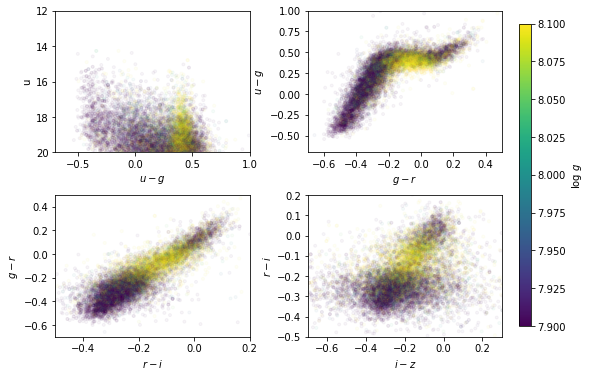

In [12]:
fig, ax = plt.subplots(2,2, figsize=(8,6))

labels = ['u', '$u-g$', '$g-r$', '$r-i$', '$i-z$']
vals = [wds['u'], wds['u']-wds['g'], wds['g']-wds['r'], wds['r']-wds['i'], wds['i']-wds['z']]
limits = [(20, 12), (-0.7,1), (-0.7, 0.5), (-0.5, 0.2), (-0.7, 0.3)]

log_g = np.clip(wds['logg'], 7.9, 8.1)

# Iterate through all four panels
for i in range(2):
    for j in range(2):
        
        # Running index
        k = 2*i + j
        
        im = ax[i,j].scatter(vals[k+1], vals[k], marker='.', c=log_g,
                             alpha=0.04, rasterized=True, cmap=plt.cm.get_cmap('viridis'))
        
        # Add labels for x- and y-axes
        ax[i,j].set_xlabel(labels[k+1])
        ax[i,j].set_ylabel(labels[k])
        
        # Set plot range
        ax[i,j].set_xlim(limits[k+1])
        ax[i,j].set_ylim(limits[k])
                
            
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax, label=r'log $g$')
cbar.set_alpha(1)
cbar.draw_all()            
    
fig.subplots_adjust(hspace=0.3, wspace=0.3)

plt.show()

### Let's discuss how might we go about doing this. Remember our discussion of how $k$-nearest neighbors can be used as a classifier. Discuss with the person sitting next to you how $k$-nearest neighbors can be applied to regression.

In the $k$-nearest neighbors classification algorithm, we discussed how the classification of one data point in arbitrarily large $N$ dimensions can be determined by finding the classification of the $k$-nearest neighbors. The $k$-nearest neighbors regression algorithm is very similar. The only thing that changes is that, instead of using the class of the $k$-nearest neighbors, you take the average of the parameters you are trying to learn from the $k$-nearest neighbors. 

The $k$-nearest neighbors algorithm is one of the easiest machine learning algorithms to both comprehend and employ.

### First, let's split up the data set into a training and test set

In [13]:
from astroML.utils import split_samples

photo_bands = ['u', 'g', 'r', 'i', 'z']

X = np.column_stack(wds[photo_bands[i]]-wds[photo_bands[i+1]] for i in range(4))
y = wds['Teff']

(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.9, 0.1],
                                                     random_state=0)

### Let's apply our algorithm, using $k$=5 neighbors

In [14]:
n_neighbors = 5

knn = neighbors.KNeighborsRegressor(n_neighbors, weights='uniform')
knn.fit(X_train, y_train)
y_out_uni = knn.predict(X_test)

### How we might go about evaluating how good our algorithm is? We want to compare the T$_{\rm eff}$ predicted by our algorithm to the T$_{\rm eff}$ values observed (see below).

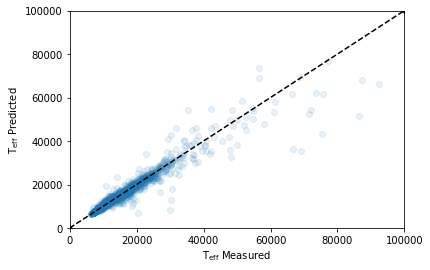

In [15]:
plt.scatter(y_test, y_out_uni, alpha=0.1)

plt.plot([0.0,1.0e5], [0.0,1.0e5], linestyle='dashed', color='k', zorder=10, marker='.')

plt.xlim(0, 1.0e5)
plt.ylim(0, 1.0e5)

plt.xlabel(r"T$_{\rm eff}$ Measured")
plt.ylabel(r"T$_{\rm eff}$ Predicted")

plt.show()

### Discuss with the person sitting next to you how can we combine this into a scalar value that serves as a metric for our model?

### Loss functions:

* L1 loss: $L$ = |T$_{\rm predicted}$ - T$_{\rm observed}$| 

* L2 loss: $L$ = (T$_{\rm predicted}$ - T$_{\rm observed}$)$^2$ 

* Huber loss: $$L = \begin{cases} 
      1/2 ({\rm T}_{\rm predicted} - {\rm T}_{\rm observed})^2 &  {\rm for}\ \left| {\rm T}_{\rm predicted} - {\rm T}_{\rm observed} \right| < d \\
      d \left( \left| {\rm T}_{\rm predicted} - {\rm T}_{\rm observed} \right| - 1/2 d\right) & {\rm for}\ \left| {\rm T}_{\rm predicted} - {\rm T}_{\rm observed} \right| > d
   \end{cases},
$$
where $d$ is a hyperparameter

In [32]:
def calc_loss(x_obs, x_pre, method='L1', huber_d=20000):

    if not method in ['L1', 'L2', 'Huber']:
        raise ValueError("The method you chose is not allowed.")

        
    if method == 'L1':
        return np.sum(np.abs(x_obs - x_pre))
    elif method == 'L2':
        return np.sum((x_obs - x_pre)**2)
    elif method == 'Huber':
        x = np.abs(x_obs-x_pre)
        return np.sum(np.piecewise(x, 
                                   [x <= huber_d, x > huber_d], 
                                   [lambda x: 0.5*x**2, lambda x: huber_d*(x - 0.5*huber_d)]))
    else:
        raise ValueError("The method you chose is not allowed.")

### Let's use these loss functions to optimize $k$

In [33]:
n_neighbors = [2, 5, 10, 15, 20, 30, 40, 50, 60, 75, 100, 125, 150]

loss_L1 = []
loss_L2 = []
loss_Huber = []

for n in n_neighbors:
    knn = neighbors.KNeighborsRegressor(n, weights='uniform')
    knn.fit(X_train, y_train)
    y_out = knn.predict(X_test)
    
    loss_L1.append(calc_loss(y_test, y_out, method='L1'))
    loss_L2.append(calc_loss(y_test, y_out, method='L2'))
    loss_Huber.append(calc_loss(y_test, y_out, method='Huber'))

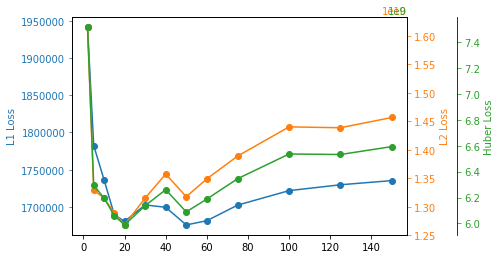

In [34]:
fig, ax1 = plt.subplots()

ax1.plot(n_neighbors, loss_L1, marker='o', linestyle='-', color='C0', label='L1')
ax1.set_ylabel('L1 Loss', color='C0')
ax1.tick_params('y', colors='C0')

ax2 = ax1.twinx()
ax2.plot(n_neighbors, loss_L2, marker='o', linestyle='-', color='C1', label='L2')
ax2.set_ylabel('L2 Loss', color='C1')
ax2.tick_params('y', colors='C1')


ax3 = ax1.twinx()
ax3.spines["right"].set_position(("axes", 1.15))
ax3.plot(n_neighbors, loss_Huber, marker='o', linestyle='-', color='C2', label='Huber')
ax3.set_ylabel('Huber Loss', color='C2')
ax3.tick_params('y', colors='C2')

plt.show()

### Depending on the loss function we go with, we might determine that either $k$=12 or $k$=50 is optimal

### The $k$-nearest neighbors algorithm is a "lazy" algorithm. No training is really necessary - except for the hyper-parameter $k$. Looking forward, we will look at algorithms that require training on a loss function. We would like to have some intuition about which loss function is optimal for our needs. Consider the similarities between the L2 loss function and $\chi^2$. 